<a href="https://colab.research.google.com/github/Jayden-Nyamiaka/Machine-Learning-and-Data-Mining/blob/main/poem_generator_miniproject3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW6 Code

In [ ]:
import os
import re
import random
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import time

In [ ]:
class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0. 
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state. 

        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.

            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.

        Parameters:
            L:          Number of states.

            D:          Number of observations.
            
            A:          The transition matrix.
            
            O:          The observation matrix.
            
            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = A
        self.O = O
        self.A_start = [1. / self.L for _ in range(self.L)]


    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state 
        sequence corresponding to a given input sequence.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

        Returns:
            max_seq:    Output sequence corresponding to x with the highest
                        probability.
        '''

        M = len(x)
        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]
        
        # for j = 1
        for i in range(self.L):
          probs[1][i] = self.A_start[i] * self.O[i][x[0]]
          seqs[1][i] = str(i) # by definition

        # for j > 1
        for j in range(2, M + 1):
          for i in range(self.L):
            p_vals = []
            seq_vals = []
            for k in range(self.L):
              p_vals.append(probs[j-1][k] * self.A[k][i] * self.O[i][x[j-1]])
              seq_vals.append(seqs[j-1][k] + str(i))
            # store maximum probability + sequence 
            probs[j][i] = max(p_vals)
            seqs[j][i] = seq_vals[p_vals.index(probs[j][i])]

        # return y^Ma (so j = M)
        max_seq = seqs[M][probs[M].index(max(probs[M]))]
        return max_seq



    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.

        Returns:
            alphas:     Vector of alphas.

                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.

                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)
        alphas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        # Initialize when j = 1 (j = 0 in the helper guide)
        for i in range(self.L):
          alphas[1][i] = self.A_start[i] * self.O[i][x[0]]
         
        # j > 0 (j > 1 in the helper guide)
        for j in range(2, M + 1):
          # equation (8) in the helper guide
          # k = alpha prime
          for i in range(self.L):
            alphas[j][i] = sum([self.A[k][i] * self.O[i][x[j-1]] * alphas[j-1][k] for k in range(self.L)]) 
          
          if normalize:
            sum_alphas = sum(alphas[j])
            alphas[j] = [ alpha / sum_alphas for alpha in alphas[j]]

        return alphas


    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.

        Returns:
            betas:      Vector of betas.

                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.

                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)
        betas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        # Initialize when j = M
        for i in range(self.L):
          betas[M][i] = 1.0

        # j < M
        # go backwards
        for j in range(M - 1, 0, -1):
          # implementing equation (9)
          for i in range(self.L):
            betas[j][i] = sum([betas[j+1][k] * self.A[i][k] * self.O[k][x[j]] for k in range(self.L)])

          if normalize:
            sum_betas = sum(betas[j])
            betas[j] = [ beta / sum_betas for beta in betas[j]]
         
        return betas


    def supervised_learning(self, X, Y):
        '''
        Trains the HMM using the Maximum Likelihood closed form solutions
        for the transition and observation matrices on a labeled
        datset (X, Y). Note that this method does not return anything, but
        instead updates the attributes of the HMM object.

        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of variable-length lists, consisting of integers 
                        ranging from 0 to D - 1. In other words, a list of
                        lists.

            Y:          A dataset consisting of state sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to L - 1. In other words, a list of
                        lists.

                        Note that the elements in X line up with those in Y.
        '''

        # Calculate each element of A using the M-step formulas.
        for curr in range(self.L):
            for nxt in range(self.L):
                num = 0.
                den = 0.

                for i in range(len(X)):
                    x = X[i]
                    y = Y[i]
                    M = len(x)
        
                    num += len([1 for i in range(M - 1) \
                                if y[i] == curr and y[i + 1] == nxt])
                    den += len([1 for i in range(M - 1) if y[i] == curr])

                self.A[curr][nxt] = num / den

        # Calculate each element of O using the M-step formulas.
        for curr in range(self.L):
            for xt in range(self.D):
                num = 0.
                den = 0.

                for i in range(len(X)):
                    x = X[i]
                    y = Y[i]
                    M = len(x)
        
                    num += len([1 for i in range(M) \
                                if y[i] == curr and x[i] == xt])
                    den += len([1 for i in range(M) if y[i] == curr])

                self.O[curr][xt] = num / den


    def unsupervised_learning(self, X, N_iters):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.

        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of variable-length lists, consisting of integers ranging
                        from 0 to D - 1. In other words, a list of lists.

            N_iters:    The number of iterations to train on.
        '''

        # Note that a comment starting with 'E' refers to the fact that
        # the code under the comment is part of the E-step.

        # Similarly, a comment starting with 'M' refers to the fact that
        # the code under the comment is part of the M-step.

        for iteration in range(1, N_iters + 1):
            # if iteration % 10 == 0:
            #     print("Iteration: " + str(iteration))

            # Numerator and denominator for the update terms of A and O.
            A_num = [[0. for i in range(self.L)] for j in range(self.L)]
            O_num = [[0. for i in range(self.D)] for j in range(self.L)]
            A_den = [0. for i in range(self.L)]
            O_den = [0. for i in range(self.L)]

            # For each input sequence:
            for x in X:
                M = len(x)
                # Compute the alpha and beta probability vectors.
                alphas = self.forward(x, normalize=True)
                betas = self.backward(x, normalize=True)

                # E: Update the expected observation probabilities for a
                # given (x, y).
                # The i^th index is P(y^t = i, x).
                for t in range(1, M + 1):
                    P_curr = [0. for _ in range(self.L)]
                    
                    for curr in range(self.L):
                        P_curr[curr] = alphas[t][curr] * betas[t][curr]

                    # Normalize the probabilities.
                    norm = sum(P_curr)
                    for curr in range(len(P_curr)):
                        P_curr[curr] /= norm

                    for curr in range(self.L):
                        if t != M:
                            A_den[curr] += P_curr[curr]
                        O_den[curr] += P_curr[curr]
                        O_num[curr][x[t - 1]] += P_curr[curr]

                    
                # E: Update the expectedP(y^j = a, y^j+1 = b, x) for given (x, y)
                for t in range(1, M):
                    P_curr_nxt = [[0. for _ in range(self.L)] for _ in range(self.L)]

                    for curr in range(self.L):
                        for nxt in range(self.L):
                            P_curr_nxt[curr][nxt] = alphas[t][curr] \
                                                    * self.A[curr][nxt] \
                                                    * self.O[nxt][x[t]] \
                                                    * betas[t + 1][nxt]

                    # Normalize:
                    norm = 0
                    for lst in P_curr_nxt:
                        norm += sum(lst)
                    for curr in range(self.L):
                        for nxt in range(self.L):
                            P_curr_nxt[curr][nxt] /= norm

                    # Update A_num
                    for curr in range(self.L):
                        for nxt in range(self.L):
                            A_num[curr][nxt] += P_curr_nxt[curr][nxt]

            for curr in range(self.L):
                for nxt in range(self.L):
                    self.A[curr][nxt] = A_num[curr][nxt] / A_den[curr]

            for curr in range(self.L):
                for xt in range(self.D):
                    self.O[curr][xt] = O_num[curr][xt] / O_den[curr]

    def generate_emission(self, M):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random. 

        Arguments:
            M:          Length of the emission to generate.

        Returns:
            emission:   The randomly generated emission as a list.

            states:     The randomly generated states as a list.
        '''

        emission = []
        state = random.choice(range(self.L))
        states = []

        for t in range(M):
            # Append state.
            states.append(state)

            # Sample next observation.
            rand_var = random.uniform(0, 1)
            next_obs = 0

            while rand_var > 0:
                rand_var -= self.O[state][next_obs]
                next_obs += 1

            next_obs -= 1
            emission.append(next_obs)

            # Sample next state.
            rand_var = random.uniform(0, 1)
            next_state = 0

            while rand_var > 0:
                rand_var -= self.A[state][next_state]
                next_state += 1

            next_state -= 1
            state = next_state

        return emission, states

    # Counts syllables
    def sonnet_generate_emission(self, num_syllabs, syllab_dict):
      emission = []
      states = []
      syl_count = 0

      state = np.random.choice(range(self.L))
      while syl_count < num_syllabs:
        e = np.random.choice(range(self.D), p = self.O[state])
        if (e in syllab_dict.keys()):
          next = int(syllab_dict[e])
          if num_syllabs >= syl_count + next:
            state = np.random.choice(range(self.L), p = self.A[state])
            emission.append(e)
            states.append(state)
            syl_count += next

      return emission, states

    def guess_state(self, om_word):
      # find the state most likely to have produced the current om_word
      probs = [state[om_word] for state in self.O]
      psum = sum(probs)
      probs = [prob / psum for prob in probs]
      rv = random.uniform(0,1)
      curr_s = 0
      while rv > 0:
        rv -= probs[curr_s]
        curr_s += 1
      return curr_s - 1

    def rhyme_generate_emission(self, num_syllabs, syllab_dict2, om_word):
      emission = []
      states = []

      # get state of rhyming word
      state = self.guess_state(om_word)
      states.append(state)
      emission.append(om_word)
      # get syllables of rhyming word
      r_syl = int(syllab_dict2[om_word])
      syllab_count = r_syl

      # create rest of sentence
      while syllab_count < num_syllabs:
        e = np.random.choice(range(self.D), p = self.O[state])
        if (e in syllab_dict2.keys()):
          next = int(syllab_dict2[e])
          if num_syllabs >= syllab_count + next:
            state = np.random.choice(range(self.L), p = self.A[state])
            emission.append(e)
            states.append(state)
            syllab_count += next

      # reverse the sentence
      emission.reverse()
      states.reverse()
      return emission, states


    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the output sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any output sequence, i.e. the
        # probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(0) gives the probability of the output sequence. Summing
        # this over all states and then normalizing gives the total
        # probability of x paired with any output sequence, i.e. the
        # probability of x.
        prob = sum([betas[1][k] * self.A_start[k] * self.O[k][x[0]] \
            for k in range(self.L)])

        return prob


def supervised_HMM(X, Y):
    '''
    Helper function to train a supervised HMM. The function determines the
    number of unique states and observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for supervised learning.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        Y:          A dataset consisting of state sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to L - 1. In other words, a list of lists.
                    Note that the elements in X line up with those in Y.
    '''
    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Make a set of states.
    states = set()
    for y in Y:
        states |= set(y)
    
    # Compute L and D.
    L = len(states)
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with labeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.supervised_learning(X, Y)

    return HMM

def unsupervised_HMM(X, n_states, N_iters,rng=np.random.RandomState(1)):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        n_states:   Number of hidden states to use in training.
        
        N_iters:    The number of iterations to train on.
        rng:        The random number generator for reproducible result.
                    Default to RandomState(1).
    '''

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)
    
    # Compute L and D.
    L = n_states
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[rng.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[rng.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM

####################
# WORDCLOUD FUNCTIONS
####################

def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r:d-r, -r:d-r]
    circle = (x**2 + y**2 <= r**2)

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

def text_to_wordcloud(text, max_words=50, title='', show=True):
    plt.close('all')

    # Generate a wordcloud image.
    wordcloud = WordCloud(random_state=0,
                          max_words=max_words,
                          background_color='white',
                          mask=mask()).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=24)
        plt.show()

    return wordcloud

def states_to_wordclouds(hmm, obs_map, max_words=50, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds

####################
# HMM FUNCTIONS
####################

def parse_observations(text):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []
        
        for word in line:
            word = re.sub(r'[^\w]', '', word).lower()
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1
            
            # Add the encoded word.
            obs_elem.append(obs_map[word])
        
        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

def sample_sentence(hmm, obs_map, n_words=100):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Sample and convert sentence.
    emission, states = hmm.generate_emission(n_words)
    sentence = [obs_map_r[i] for i in emission]

    # return ' '.join(sentence).capitalize() + '...'
    return ' '.join(sentence).capitalize() 


####################
# HMM VISUALIZATION FUNCTIONS
####################

def visualize_sparsities(hmm, O_max_cols=50, O_vmax=0.1):
    plt.close('all')
    plt.set_cmap('viridis')

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title('Sparsity of A matrix')
    plt.show()

    # Visualize parsity of O.
    plt.imshow(np.array(hmm.O)[:, :O_max_cols], vmax=O_vmax, aspect='auto')
    plt.colorbar()
    plt.title('Sparsity of O matrix')
    plt.show()


####################
# HMM ANIMATION FUNCTIONS
####################

def animate_emission(hmm, obs_map, M=8, height=12, width=12, delay=1):
    # Parameters.
    lim = 1200
    text_x_offset = 40
    text_y_offset = 80
    x_offset = 580
    y_offset = 520
    R = 420
    r = 100
    arrow_size = 20
    arrow_p1 = 0.03
    arrow_p2 = 0.02
    arrow_p3 = 0.06
    
    # Initialize.
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = states_to_wordclouds(hmm, obs_map, max_words=20, show=False)

    # Initialize plot.    
    fig, ax = plt.subplots()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax.grid('off')
    plt.axis('off')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])

    # Plot each wordcloud.
    for i, wordcloud in enumerate(wordclouds):
        x = x_offset + int(R * np.cos(np.pi * 2 * i / n_states))
        y = y_offset + int(R * np.sin(np.pi * 2 * i / n_states))
        ax.imshow(wordcloud.to_array(), extent=(x - r, x + r, y - r, y + r), aspect='auto', zorder=-1)

    # Initialize text.
    text = ax.text(text_x_offset, lim - text_y_offset, '', fontsize=24)
        
    # Make the arrows.
    zorder_mult = n_states ** 2 * 100
    arrows = []
    for i in range(n_states):
        row = []
        for j in range(n_states):
            # Arrow coordinates.
            x_i = x_offset + R * np.cos(np.pi * 2 * i / n_states)
            y_i = y_offset + R * np.sin(np.pi * 2 * i / n_states)
            x_j = x_offset + R * np.cos(np.pi * 2 * j / n_states)
            y_j = y_offset + R * np.sin(np.pi * 2 * j / n_states)
            
            dx = x_j - x_i
            dy = y_j - y_i
            d = np.sqrt(dx**2 + dy**2)

            if i != j:
                arrow = ax.arrow(x_i + (r/d + arrow_p1) * dx + arrow_p2 * dy,
                                 y_i + (r/d + arrow_p1) * dy + arrow_p2 * dx,
                                 (1 - 2 * r/d - arrow_p3) * dx,
                                 (1 - 2 * r/d - arrow_p3) * dy,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))
            else:
                arrow = ax.arrow(x_i, y_i, 0, 0,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))

            row.append(arrow)
        arrows.append(row)

    emission, states = hmm.generate_emission(M)

    def animate(i):
        if i >= delay:
            i -= delay

            if i == 0:
                arrows[states[0]][states[0]].set_color('red')
            elif i == 1:
                arrows[states[0]][states[0]].set_color((1 - hmm.A[states[0]][states[0]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')
            else:
                arrows[states[i - 2]][states[i - 1]].set_color((1 - hmm.A[states[i - 2]][states[i - 1]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')

            # Set text.
            text.set_text(' '.join([obs_map_r[e] for e in emission][:i+1]).capitalize())

            return arrows + [text]

    # Animate!
    print('\nAnimating...')
    anim = FuncAnimation(fig, animate, frames=M+delay, interval=1000)

    return anim

# Imports

In [ ]:
import pandas as pd
import requests
from numpy import genfromtxt
import torch
import torch.nn as nn
import torch.optim as optim

# Helper Functions

In [ ]:
# Parse observations from HW6 but removes headers
def parse_observations(text):
    # Convert text to dataset.
    # Removes sonnet headers.
    lines = [line.split() for line in text.split('\n') if len(line.split()) > 1]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []
        
        for word in line:
            word = re.sub(r'[^\w]', '', word).lower()
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1
            
            # Add the encoded word.
            obs_elem.append(obs_map[word])
        
        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

# Data Pre-Processing

In [ ]:
# Loads and processes shakespeare.txt
shakespeare_text = 'https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject3/data/shakespeare.txt'
shakespeare = requests.get(shakespeare_text).text
obs, obs_map = parse_observations(shakespeare)

In [ ]:
# Syllable dictionary
def syllab_dict_gen(obs_map):
  syllable_dict_text = 'https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject3/data/Syllable_dictionary.txt'
  syllable_dict = requests.get(syllable_dict_text).text
  syllable_dict = [line.split() for line in syllable_dict.split('\n') if line.split()] 

  # Remove punctuation, convert to lower case
  for i in range(len(syllable_dict)):
    syllable_dict[i][0] = re.sub(r'[^\w]', '', syllable_dict[i][0]).lower()

  # Helps count syllables
  syllab_dict = {}
  syllab_dict_2 = {}

  for row in syllable_dict:
    word = row[0]
    if row[1].isdigit():
      syllab_dict[word] = int(row[1])
      if word in obs_map:
        syllab_dict_2[obs_map[word]] = int(row[1])
    else:
      syllab_dict[word] = int(row[2])
      if word in obs_map:
        syllab_dict_2[obs_map[word]] = int(row[2])
  return (syllab_dict, syllab_dict_2)

In [ ]:
(syllab_dict, syllab_dict_2) = syllab_dict_gen(obs_map)

# Unsupervised Learning

See above (Reusing HW 6 code)

# Poetry Generation, Part 1: HMM - Naive Poem Generation

In [ ]:
def generate_naive_sonnet(hmm, obs_map, n_words):
  sonnet = ''
  for line in range(14):
      if line % 4 == 0:
        sonnet += '\n'
      sentence = sample_sentence(hmm, obs_map, n_words = n_words)
      num_syllab = 0

      for word in sentence.split():
        if word.lower() in syllab_dict.keys(): 
          num_syllab += syllab_dict[word.lower()]

      sent = list(sentence)
      caps = ["i", "o"]

      for i in range(len(sent)):
        if sent[i] in caps:
          if i == 0:
            if sent[i + 1] == " ":
              sent[i] = sent[i].capitalize()
          elif i == len(sent) - 1:
            if sent[i - 1] == " ":
              sent[i] = sent[i].capitalize()
          else:
            if sent[i - 1] == sent[i + 1] and sent[i - 1] == " ":
              sent[i] = sent[i].capitalize()

      sentence = "".join(sent)

      if line > 11:
        sonnet += '  '
      sonnet += sentence + '\n'
      
  print(sonnet)

In [ ]:
hmm_01 = unsupervised_HMM(obs, 1, 100)
generate_naive_sonnet(hmm_01, obs_map, n_words = np.random.choice([7,8]))


Palate other of the got needs my thou
Frown leave image my be main taste your
Burn cheer livery gored his dead and each
Ere when or your with is memory more

About rich add not times your my beauteous
Loves seeing swear how answer others shall such
It to is ripe was natures the thy
Whose shun of it from and suborned glass

Most to the vermilion breath is perceive worst
Eyes that in you basest of I worth
My rest call me absent thy beauty me
Terms amis haste make flower where think so

  I four strong brain seen and besides lie
  And oblivion divine purity be with and your



In [ ]:
hmm_10 = unsupervised_HMM(obs, 10, 100)
generate_naive_sonnet(hmm_10, obs_map, n_words = np.random.choice([7,8]))


Clouds to sooner alive live such crime
Beautys old that usest maturity are nature
Others love to gilded lives increase on
My I night fire with would divert

No my self yet of and for
More image by farthest kindhearted far black
Fall you now against of this most
Dwells or before for my firm those

No desire thou woo eyes in you
Self of at their the as the
Thy numbers grief that that thou hymns
When for despite bounty sight proud him

  How my parts were my sun to
  Who my can eyes thee minutes some



In [ ]:
hmm_15 = unsupervised_HMM(obs, 15, 100)
generate_naive_sonnet(hmm_15, obs_map, n_words = np.random.choice([7,8]))


Thy a where whence as no and
Thee more lie and water before him
Self the sure and day with had
Admit female it this and loves doth

Writes praise it be nothing eternal both
Woe looks read under I can thee
Bright ye here chest to this suspect
Fulness love made me indeed not but

Cry thou see give bark my my
Do you a growth the are abuse
Angel and my sweets fire she it
With now their and the map forth

  Dead peace this fortunes so bereft the
  Am my that ill best in the



# Additional Goals

Rhyme

In [ ]:
def rhyme_dict_gen (obs_map):
  # Rhyme dictionary
  rhyme_dict = shakespeare
  rhyme_dict = [line.split() for line in rhyme_dict.split('\n') if len(line.split()) > 0]

  # Keep the last word with punctuation removed
  # Remove Punctuation, covert to lower case
  for i in range(len(rhyme_dict)):
    rhyme_dict[i] = re.sub(r'[^\w]', '', rhyme_dict[i][-1]).lower()

  # Initialize two rhyming dictionaries (str -> [str]) and (int -> [str])
  rhyme_res = {}
  rhyme_res_2 = {}

  line_count = 0
  rhyme_arr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  rhyming_pairs = [[0, 2], [1, 3], [4, 6], [5, 7], [8, 10], [9, 11], [12, 13]]
  for arr in rhyme_dict:
    line_c = (line_count % 15)
    if line_c != 0:
      rhyme_arr[line_c - 1] = arr
    else:
      if rhyme_arr[0] != 0 and arr.isnumeric():
        for pair in rhyming_pairs:
          rhyme_res[rhyme_arr[pair[0]]] = rhyme_arr[pair[1]]
          rhyme_res[rhyme_arr[pair[1]]] = rhyme_arr[pair[0]]
          rhyme_res_2[obs_map[rhyme_arr[pair[0]]]] = rhyme_arr[pair[1]]
          rhyme_res_2[obs_map[rhyme_arr[pair[1]]]] = rhyme_arr[pair[0]]
        rhyme_arr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    line_count += 1
  
  return (rhyme_res, rhyme_res_2)

In [ ]:
(rhyme_dict, rhyme_dict_2) = rhyme_dict_gen(obs_map)

In [ ]:
print(rhyme_dict)

{'increase': 'decease', 'decease': 'increase', 'die': 'dignity', 'memory': 'eternity', 'eyes': 'devise', 'lies': 'eyes', 'fuel': 'cruel', 'cruel': 'fuel', 'ornament': 'content', 'content': 'ornament', 'spring': 'thing', 'niggarding': 'spring', 'be': 'decree', 'thee': 'me', 'brow': 'now', 'now': 'bow', 'field': 'held', 'held': 'stelled', 'days': 'praise', 'praise': 'days', 'use': 'muse', 'excuse': 'use', 'mine': 'thine', 'thine': 'mine', 'old': 'told', 'cold': 'behold', 'viewest': 'renewest', 'renewest': 'viewest', 'another': 'mother', 'mother': 'another', 'womb': 'tomb', 'tomb': 'dumb', 'husbandry': 'posterity', 'posterity': 'enmity', 'see': 'thee', 'prime': 'time', 'time': 'prime', 'spend': 'tend', 'lend': 'friend', 'legacy': 'free', 'free': 'legacy', 'abuse': 'use', 'give': 'live', 'live': 'give', 'alone': 'anon', 'gone': 'moan', 'deceive': 'leave', 'leave': 'deceive', 'frame': 'same', 'same': 'name', 'dwell': 'tell', 'excel': 'dwell', 'on': 'groan', 'there': 'forbear', 'where': 'cle

In [ ]:
# Rhyming based off of sample_sentence function
def rhyme_sample_sentences(hmm, obs_map, n_syllab, n_pairs, syllab_dict_2, rhyme_dict):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    all_sentences = []

    # Creates 2 * n_pairs number of sentences
    for _ in range(n_pairs):
      # Get rhyming words 
      # From Halle's
      rhyme_pair = key, val = random.choice(list(rhyme_dict.items()))
      emission, states = hmm.rhyme_generate_emission(n_syllab, syllab_dict_2, obs_map[key])
      sentence = [obs_map_r[i] for i in emission]
      all_sentences.append(' '.join(sentence).capitalize())

      emission, states = hmm.rhyme_generate_emission(n_syllab, syllab_dict_2, obs_map[val])
      sentence = [obs_map_r[i] for i in emission]
      all_sentences.append(' '.join(sentence).capitalize())

    return all_sentences

In [ ]:
# Helper function to print out sonnet
def generate_rhyming_sonnet(hmm, obs_map):
  sonnet = ''
  sentences = rhyme_sample_sentences(hmm, obs_map, 10, 7, syllab_dict_2, rhyme_dict)
  for line in range(14):
      num_syllab = 0
      sentence = sentences[line]
      for word in sentence.split():
          if word.lower() in syllab_dict.keys(): 
            num_syllab += syllab_dict[word.lower()]

      words = list(sentence)
      caps = ["i", "o"]

      # Capitalizes code from Halle's generate_naive_sonnet
      for i in range(len(words)):
        if words[i] in caps:
          if i == 0:
            if words[i + 1] == " ":
              words[i] = words[i].capitalize()
          elif i == len(words) - 1:
            if words[i - 1] == " ":
              words[i] = words[i].capitalize()
          else:
            if words[i - 1] == words[i + 1] and words[i - 1] == " ":
              words[i] = words[i].capitalize()

      sentence = "".join(words)
      sentences[line] = sentence

  # Place the sentences in the right order
  rhyming_pairs = [0, 2, 1, 3, 4, 6, 5, 7, 8, 10, 9, 11, 12, 13]
  for i in range(len(sentences)):
    if rhyming_pairs[i] > 11:
      sonnet += '  '
    sonnet += sentences[rhyming_pairs[i]] + '\n'
      
  print(sonnet)

In [ ]:
hmm_01_rhyme = unsupervised_HMM(obs, 1, 100)
print("Rhyming Poem Generation with 1 Hidden State\n")
generate_rhyming_sonnet(hmm_01_rhyme, obs_map)

Rhyming Poem Generation with 1 Hidden State

Limping me that living shall that adieu
My hymns are straight with feeding and thou rare
To love she give reap delivers that you
Wherefore dost needst I name making or care
To a as thy me but all wantonly
Thing hell book what patience day excellence
And whilst mine for and those never bide dye
Tears to have uncertain when thorns expense
You him thy to tongues remover dear will
Thievish glass from I willingly the trust
Flower chide fled other not any is ill
This swift a know in to respect you thrust
  Saw might is eyed I shall on to translate
  Find disperse or makst nimble spend prime state



In [ ]:
hmm_10_rhyme = unsupervised_HMM(obs, 10, 100)
print("Rhyming Poem Generation with 10 Hidden States\n")
generate_rhyming_sonnet(hmm_10_rhyme, obs_map)

Rhyming Poem Generation with 10 Hidden States

Gone guard bare hand all then wilt thee me thine
Loves thy bore tonguetied and which nor proceed
Not I hath beauty a perfumes thy mine
I time all noted ceremony weed
Day my stand bears silent moan controlling
Might a give which outward even thy from check
Goodness grace invention it me rolling
Own it may gold thee think own do they beck
It on him such strangle being making blot
Of this my by still sufferance my mock prove
Die good so am cured want veins to truth got
Doth to some thou brand sight of turns fire love
  Queen that moan you or beauty argument
  His for youths that unlettered in invent



In [ ]:
hmm_15_rhyme = unsupervised_HMM(obs, 15, 100)
print("Rhyming Poem Generation with 10 Hidden States\n")
generate_rhyming_sonnet(hmm_15_rhyme, obs_map)

Counting Syllables

In [ ]:
# Counting syllables based off of sample_sentence function
def sample_sentence_syllable(hmm, obs_map, n_syllab, syllab_dict_2):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Sample and convert sentence.
    emission, states = hmm.sonnet_generate_emission(n_syllab, syllab_dict_2)
    sentence = [obs_map_r[i] for i in emission]
    full_sentence = ' '.join(sentence).capitalize() 

    return full_sentence

Other Poetic Forms: Haiku

In [ ]:
with open('haiku.txt', 'r') as file:
    haiku = file.read()

obs_haiku, obs_map_haiku = parse_observations(haiku)

FileNotFoundError: ignored

In [ ]:
(syllab_dict_haiku, syllab_dict_2_haiku) = syllab_dict_gen(obs_map_haiku)

NameError: ignored

In [ ]:
# Helper function to print out sonnet
def generate_naive_haiku(hmm, obs_map):
  # Haiku
  # a short, unrhymed poem
  # three lines, 17 syllables in total
  # the first and the third lines have 5 syllables each
  # the second line has 7 syllables
  # requirements: kireji (cutting words), kigo (seasonal reference)
  haiku = ''
  for line in range(3):
      max_syllables = 7 if line == 1 else 5
      sentence = sample_sentence_syllable(hmm, obs_map, max_syllables, syllab_dict_2_haiku) # from HW6
      # Track the number of syllables for each line
      num_syllables = 0

      sentence_cut = ''

      for word in sentence.split():
        if num_syllables <= max_syllables:
          if word.lower() in syllab_dict.keys(): 
            num_syllables += syllab_dict[word.lower()]
            sentence_cut += word
            sentence_cut += " "

      # Implements proper spacing
      haiku += "(syllables: " + str(num_syllables) + ") "
      haiku += sentence_cut + '\n'
      
  print(haiku)

In [ ]:
hmm_01_haiku = unsupervised_HMM(obs, 1, 100)
print("Haiku with 1 hidden state and 100 iterations\n")
generate_haiku_syllab_count(hmm01_haiku, obs_map, n_syllabs=[5,7,5] , syllab

In [ ]:
hmm_10_haiku = unsupervised_HMM(obs_haiku, 10, 100)
print("Haiku with 10 hidden states and 100 iterations\n")
generate_naive_haiku(hmm_10_haiku, obs_map_haiku)

In [ ]:
hmm_15_haiku = unsupervised_HMM(obs_haiku, 15, 100)
print("Haiku with 15 hidden states and 100 iterations")
generate_naive_haiku(hmm_15_haiku, obs_map_haiku)

# Add in Spencer's Sonnets

In [ ]:
shakespeare_text = 'https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject3/data/shakespeare.txt'
spencer_text = 'https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject3/data/spenser.txt'
shakespeare = requests.get(shakespeare_text).text
spencer = requests.get(spencer_text).text
combined = shakespeare + spencer
#obs2, obs_map2 = parse_observations(shakespeare)
#obs3, obs_map3 = parse_observations(spencer)
obs4, obs_map4 = parse_observations(combined)
print(obs4)
print(obs_map4)

[[0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11, 12], [13, 14, 15, 16, 17, 18, 19, 20], [21, 22, 23, 10, 24, 21, 25], [13, 26, 27, 28, 29, 30, 31, 32], [33, 34, 35, 36, 37, 38, 39], [40, 41, 42, 43, 44, 45], [34, 46, 34, 47, 28, 34, 48, 46, 49, 50], [26, 6, 51, 52, 15, 53, 54, 55], [56, 57, 58, 28, 15, 59, 60], [61, 29, 30, 62, 63, 34, 64], [56, 22, 65, 66, 67, 68, 69], [70, 15, 71, 72, 73, 74, 75, 76], [28, 77, 15, 53, 78, 18, 15, 79, 56, 80], [81, 82, 83, 84, 85, 34, 86], [56, 87, 88, 89, 68, 34, 8, 90], [34, 91, 92, 93, 94, 95, 96, 52], [97, 76, 41, 98, 99, 100, 101, 102, 103], [104, 105, 106, 43, 107, 34, 108, 45], [43, 107, 15, 109, 100, 34, 110, 111], [28, 112, 61, 29, 30, 88, 113, 32], [114, 115, 116, 117, 56, 118, 119], [120, 121, 122, 119, 123, 34, 8, 124], [125, 26, 126, 127, 74, 128, 129, 100, 130], [84, 131, 132, 133, 56, 134, 132, 135, 136], [137, 21, 108, 18, 138, 29], [74, 114, 28, 76, 139, 140, 81, 26, 51, 135], [56, 141, 34, 142, 143, 81, 26, 144, 145, 146], [147, 68, 34, 148

In [ ]:
hmm_comb = unsupervised_HMM(obs4, 1, 100)
generate_naive_sonnet(hmm_comb, obs_map4, n_words = np.random.choice([7,8]))


She cruel is the thy sufficeth she life
His ill himself glass contains still any to
Storms am briar they rent mourning buried that
At sweet their and must happier of it

Dost son thrive to pleasure souls hath virtue
Will despair upon lie indias will wherefore the
Of sun on to fair you all you
Wound than live think in selfdoing so when

Rich I make perjured ride no consent from
Chest whiles if own of their heart but
Thou than on care malady strongly and ne
Than lifes mine green golden be inquire mine

  Your did lovekindling out yet my hold could
  Praising the there fair store her how glorious



In [ ]:
hmm_comb10 = unsupervised_HMM(obs4, 10, 100)

In [ ]:
generate_naive_sonnet(hmm_comb10, obs_map4, n_words = np.random.choice([7,8]))


Bids then bases nor calms in rest with
That thou of this she one that victors
Chose sorry faces merit as she to attend
Nought should death graceth all you whereof this

When all love emprize sweet to fade to
Bough such unto my brow debt day your
My fine the thee false hercules the your
Cuckoo gildst dear merchants faults of with sun

Both these worth disdaineth in the wound or
Sacred mirth ornament is fry is is friends
Made loves perfection which truths in thereon doth
Gravity work thee tomb no sundry they life

  Besiege brains be with a damsel debate who
  Most taste green your heaven are I act



In [ ]:
# make a rhyming sonnet with spencer poems too
generate_rhyming_sonnet(hmm_comb2, obs_map4)

My see to of worst the eyes shall heart wrong
Poor with and forth hence since be lively thrive
So youths richly princes art since belong
When to seeing kill less you to derive
Thy strange seek will ruth she absence sweet sang
Is grace my defaced fiery of commits
Was extreme nights a and not thoughts my hang
Faith trenches thee than most your most befits
To will gave old the of being be shall hell
Cruel to length fruit than sire or no his
Self the not will patience tender not well
After when to is her sweet them will is
  When but her on in as their in faces
  Is three my sweet and to show should graces



# Visualization and Interpretation

In [ ]:
# visualizations with only shakespeare text

In [ ]:
hmm = unsupervised_HMM(obs, 10, 100)

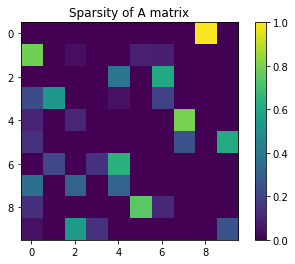

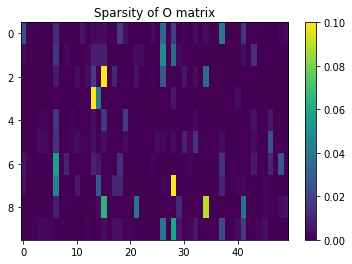

In [ ]:
visualize_sparsities(hmm, O_max_cols=50)

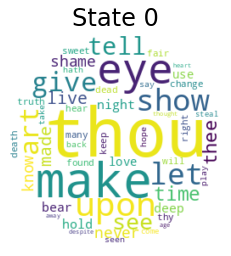

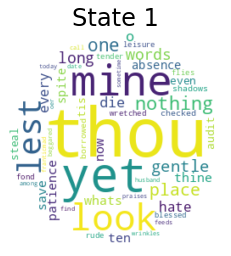

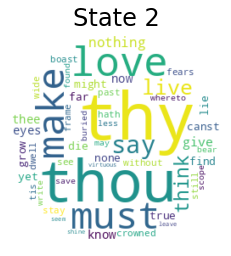

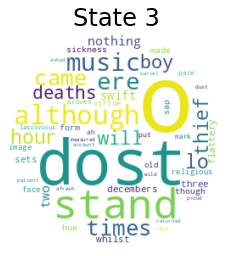

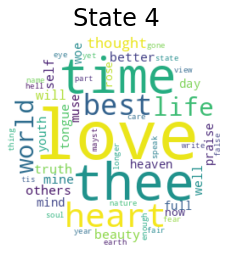

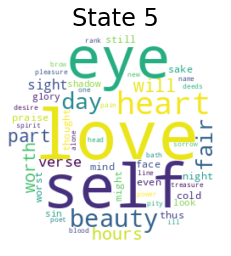

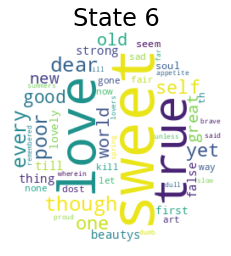

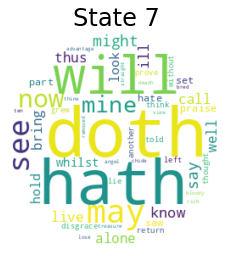

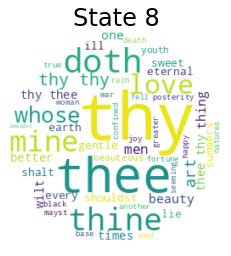

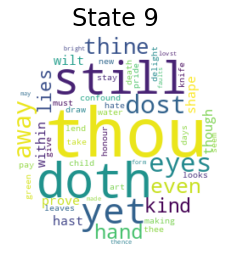

In [ ]:
wordclouds = states_to_wordclouds(hmm, obs_map)

In [ ]:
hmm12 = unsupervised_HMM(obs, 12, 100)

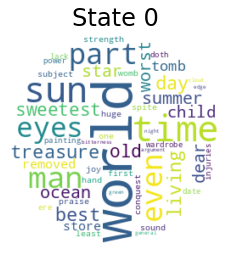

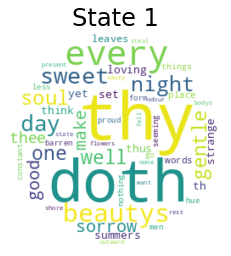

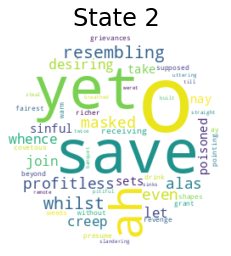

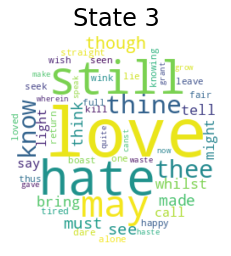

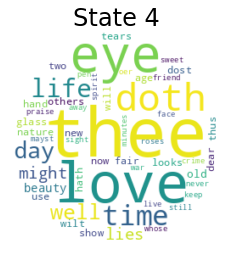

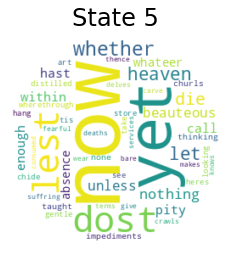

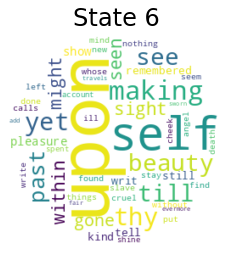

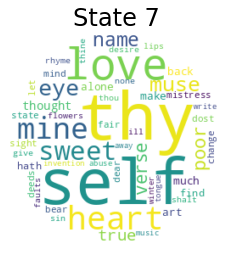

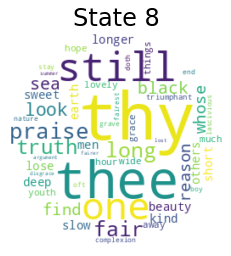

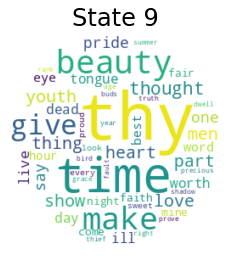

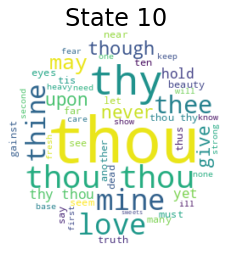

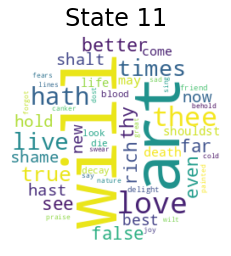

In [ ]:
wordclouds = states_to_wordclouds(hmm12, obs_map)

In [ ]:
from IPython.display import HTML


Animating...


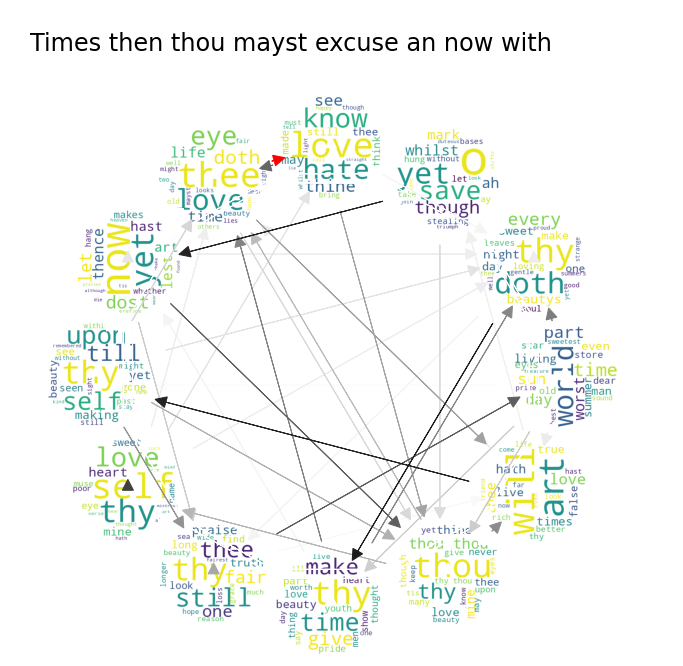

In [ ]:
anim = animate_emission(hmm12, obs_map, M=8)
HTML(anim.to_html5_video())

# Visualizations with Spencer Poems Included in Dataset


In [ ]:
# obs4, obs_map4, and hmm_comb are the variables including the spencer poems
# hmm_comb5 has 5 hidden layer, hmm_comb10 has 10 hidden layers

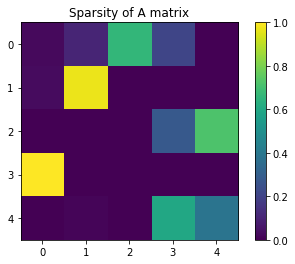

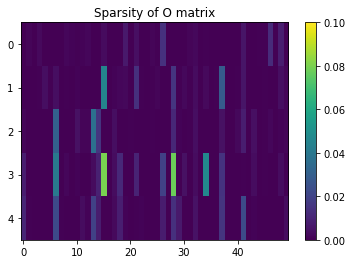

In [ ]:
# 5 hidden layers
hmm_comb5 = unsupervised_HMM(obs4, 5, 100)
visualize_sparsities(hmm_comb5, O_max_cols=50)

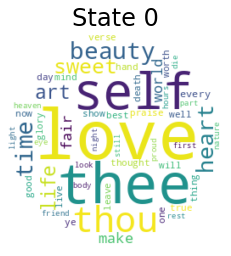

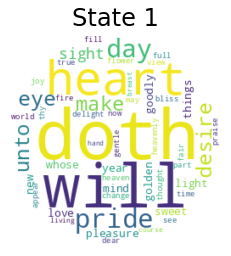

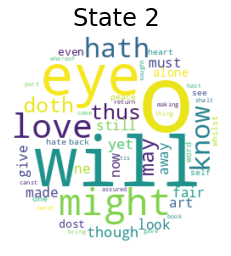

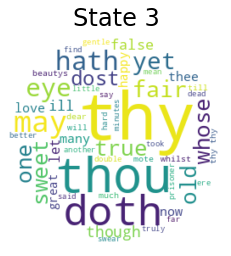

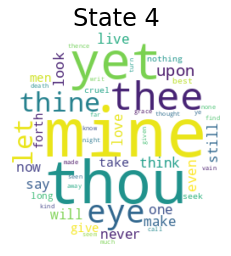

In [ ]:
wordclouds = states_to_wordclouds(hmm_comb5, obs_map4)

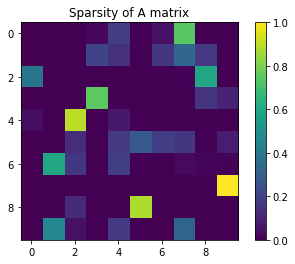

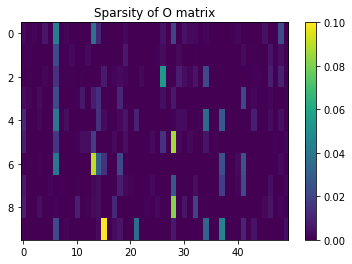

In [ ]:
# 10 hidden layers
hmm_comb10 = unsupervised_HMM(obs4, 10, 100)
visualize_sparsities(hmm_comb10, O_max_cols=50)

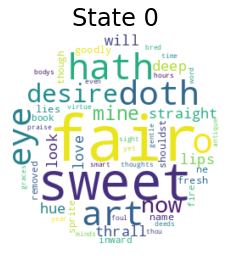

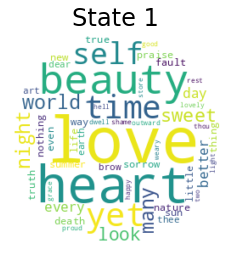

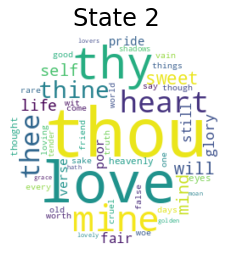

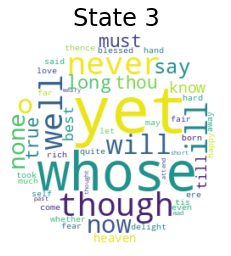

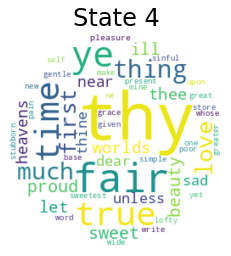

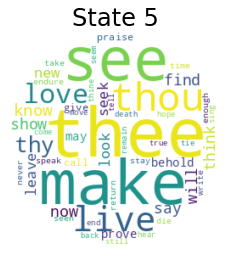

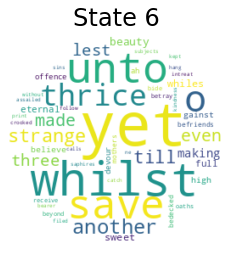

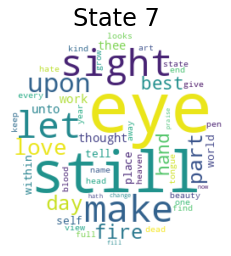

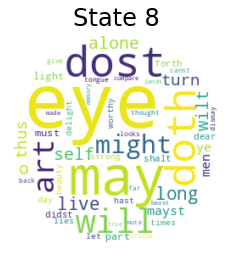

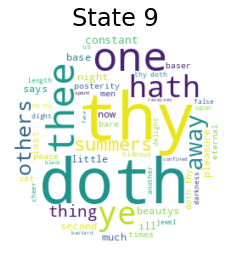

In [ ]:
wordclouds = states_to_wordclouds(hmm_comb10, obs_map4)


Animating...


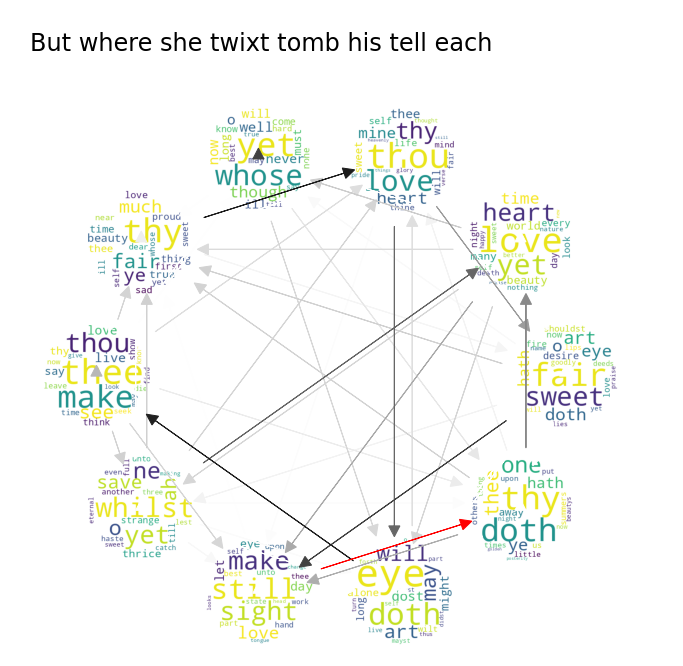

In [ ]:
anim = animate_emission(hmm_comb10, obs_map4, M=8)
HTML(anim.to_html5_video())